In [1]:
import os
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.path.pardir, 'gotmtool'))
from gotmtool import *

## Case parameters

In [2]:
casename = 'lsc_ymc22_sbl_bbl_v2_rf'
g = 9.81
u10 = 8
cd = 1.25e-3
rhoa = 1.225
rhoo = 1026
tau = rhoa * cd * u10 * u10
U0 = -0.25
f = 1e-4
dpdy = -f*U0
dhdy = dpdy/g

## Create a model

In [3]:
m = Model(name=casename, environ=os.path.join(os.path.pardir, 'gotmtool', '.gotm_env.yaml'))

Take a look at what are defined in the environment file.

In [4]:
for key in m.environ:
    print('{:>15s}: {}'.format(key, m.environ[key]) )

   gotmdir_code: /data1/scratch/qingli/project/A2024_CmpFlux/gotm/code
   gotmdir_data: /data1/scratch/qingli/project/A2024_CmpFlux/gotm/data
  gotmdir_build: /data1/scratch/qingli/project/A2024_CmpFlux/gotm/build
    gotmdir_exe: /data1/scratch/qingli/project/A2024_CmpFlux/gotm/exe
    gotmdir_run: /data1/scratch/qingli/project/A2024_CmpFlux/gotm/run
 gotmdir_figure: /data1/scratch/qingli/project/A2024_CmpFlux/gotm/figure
   gotmdir_tool: /data1/scratch/qingli/project/A2024_CmpFlux/gotmtool


## Build the model

In [5]:
%%time
m.build()

CPU times: user 13 ms, sys: 41.7 ms, total: 54.8 ms
Wall time: 123 ms


## Configuration
Initialize the GOTM configuration

In [6]:
cfg = m.init_config()

Generating default configuration at '/data1/scratch/qingli/project/A2024_CmpFlux/gotm/run/lsc_ymc22_sbl_bbl_v2_rf/gotm.yaml'...
Done!


 ------------------------------------------------------------------------
 GOTM started on 2024/10/17 at 15:15:00
 ------------------------------------------------------------------------
    initialize_gotm
 ------------------------------------------------------------------------
        Reading configuration from: gotm.yaml
        configuring modules ....
    init_airsea_yaml
        done
    init_observations_yaml
    init_stokes_drift_yaml
        done
    init_turbulence_yaml
        done.
    init_cvmix_yaml
        done.
    init_meanflow_yaml
        done
    init_eqstate_yaml
    init_density()
            rho0=     1027.0000000000000     
        done.
 Your configuration has been written to /data1/scratch/qingli/project/A2024_CmpFlux/gotm/run/lsc_ymc22_sbl_bbl_v2_rf/gotm.yaml.
STOP 0


Update the configuration

In [7]:
# setup
title = 'Merging boundary layers'
nlev = 144
depth = 30.0
cfg['title'] = title
cfg['location']['name'] = 'Idealized'
cfg['location']['latitude'] = 45.0
cfg['location']['longitude'] = 0.0
cfg['location']['depth'] = depth
cfg['time']['start'] = '2000-01-01 00:00:00'
cfg['time']['stop']  = '2000-01-13 00:00:00'
cfg['time']['dt']    = 60.0
cfg['grid']['nlev']  = nlev

# output
cfg['output'] = {}
cfg['output']['gotm_out'] = {}
cfg['output']['gotm_out']['use'] = True
cfg['output']['gotm_out']['title'] = title
cfg['output']['gotm_out']['k1_stop'] = nlev+1
cfg['output']['gotm_out']['k_stop'] = nlev
cfg['output']['gotm_out']['time_unit'] = 'dt'
cfg['output']['gotm_out']['time_step'] = 3
cfg['output']['gotm_out']['variables'] = [{}]
cfg['output']['gotm_out']['variables'][0]['source'] = '*'

# forcing
datadir = os.path.join(m.environ['gotmdir_data'], casename)
cfg['temperature']['method'] = 'file'
cfg['temperature']['file'] = os.path.join(datadir, 't_prof.dat')
cfg['temperature']['type'] = 'potential'
cfg['salinity']['method'] = 'constant'
cfg['salinity']['constant_value'] = 35.0
cfg['surface']['fluxes']['heat']['method'] = 'constant'
cfg['surface']['fluxes']['heat']['constant_value'] = 0.0
cfg['surface']['fluxes']['tx']['method'] = 'constant'
cfg['surface']['fluxes']['tx']['constant_value'] = tau
cfg['surface']['fluxes']['ty']['method'] = 'constant'
cfg['surface']['fluxes']['ty']['constant_value'] = 0.0
cfg['surface']['swr']['method'] = 'constant'
cfg['surface']['precip']['method'] = 'constant'
cfg['mimic_3d']['ext_pressure']['type'] = 'elevation'
cfg['mimic_3d']['ext_pressure']['dpdy']['method'] = 'constant'
cfg['mimic_3d']['ext_pressure']['dpdy']['constant_value'] = dhdy
cfg['bottom']['h0b'] = 0.01
cfg['velocities']['u']['method'] = 'file'
cfg['velocities']['u']['file'] = os.path.join(datadir, 'u_prof.dat')
cfg['velocities']['u']['column'] = 1
cfg['velocities']['v']['method'] = 'file'
cfg['velocities']['v']['file'] = os.path.join(datadir, 'u_prof.dat')
cfg['velocities']['v']['column'] = 2

# Stokes drift
cfg['waves']['stokes_drift']['us']['method'] = 'file'
cfg['waves']['stokes_drift']['vs']['method'] = 'file'
cfg['waves']['stokes_drift']['us']['file'] = 'us_prof.dat'
cfg['waves']['stokes_drift']['us']['column'] = 1
cfg['waves']['stokes_drift']['vs']['file'] = 'us_prof.dat'
cfg['waves']['stokes_drift']['vs']['column'] = 2
# cfg['waves']['stokes_drift']['dusdz']['method'] = 'us'
# cfg['waves']['stokes_drift']['dvsdz']['method'] = 'vs'
cfg['waves']['stokes_drift']['dusdz']['method'] = 'file'
cfg['waves']['stokes_drift']['dvsdz']['method'] = 'file'
cfg['waves']['stokes_drift']['dusdz']['file'] = 'dusdz_prof.dat'
cfg['waves']['stokes_drift']['dusdz']['column'] = 1
cfg['waves']['stokes_drift']['dvsdz']['file'] = 'dusdz_prof.dat'
cfg['waves']['stokes_drift']['dvsdz']['column'] = 2

# EOS -- use linear
cfg['equation_of_state']['method'] = 'linear_custom'
cfg['equation_of_state']['rho0'] = rhoo
cfg['equation_of_state']['linear']['T0'] = 20.0
cfg['equation_of_state']['linear']['S0'] = 35.0
cfg['equation_of_state']['linear']['alpha'] = 2.0e-4
cfg['equation_of_state']['linear']['beta'] = 8.0e-4

# water type (Jerlov IB)
cfg['light_extinction']['method'] = 'jerlov-ib'

### Turbulence closure scheme


In [8]:
# collect the configurations and the labels of the two runs
cfgs = []
labels = []

In [9]:
cfg['turbulence']['turb_method'] = 'cvmix'
cfg['cvmix']['surface_layer']['use'] = True
cfg['cvmix']['surface_layer']['langmuir_method'] = 'lf17'
cfg['cvmix']['bottom_layer']['use'] = True
cfg['cvmix']['interior']['use'] = True
cfg['cvmix']['interior']['background']['use'] = True
cfg['cvmix']['interior']['shear']['use'] = True
cfgs.append(copy.deepcopy(cfg))
labels.append('KPPLT-LF17')

In [10]:
cfg['temperature']['relax']['tau'] = 60.0
cfg['velocities']['relax']['tau'] = 60.0
cfgs.append(copy.deepcopy(cfg))
labels.append('KPPLT-LF17-Rlx')

In [11]:
cfg['temperature']['relax']['tau'] = 1.0e15
cfg['velocities']['relax']['tau'] = 1.0e15

cfg['turbulence']['turb_method'] = 'second_order'
cfg['turbulence']['tke_method'] = 'mellor_yamada'
cfg['turbulence']['len_scale_method'] = 'mellor_yamada'
cfg['turbulence']['scnd']['method'] =  'quasi_eq_h15'
cfg['turbulence']['scnd']['scnd_coeff'] =  'kantha_clayson'
cfg['turbulence']['turb_param']['length_lim'] = 'false'
cfg['turbulence']['turb_param']['compute_c3'] = 'false'
cfg['turbulence']['my']['e3'] = 5.0
cfg['turbulence']['my']['e6'] = 6.0
cfgs.append(copy.deepcopy(cfg))
labels.append('SMCLT-H15')

In [12]:
cfg['temperature']['relax']['tau'] = 60.0
cfg['velocities']['relax']['tau'] = 60.0
cfgs.append(copy.deepcopy(cfg))
labels.append('SMCLT-H15-Rlx')

### Stokes drift

Stokes drift according to Eq (5) of [Yan et al., 2022](https://doi.org/10.1175/JPO-D-21-0067.1) is
$$
u_s = U_s\frac{\cosh[2k(z+H)]}{2\sinh^2(kH)}
$$
where $k$ is the wavenumber, $H$ is the water depth, $U_s=\sigma_w k a_w^2$ is the surface value of Stokes drift, with $\sigma_w$ the frequency and $a_w$ the amplitude.

The vertical shear of this Stokes drift is
$$
\frac{d u_s}{dz} = U_s k \frac{\sinh[2k(z+H)]}{\sinh^2(kH)}
$$

In [13]:
amplitude = 1.13 # m
wavelength = 60. # m
wavenumber = 2. * np.pi / wavelength # 1/m
frequency = np.sqrt(g * wavenumber * np.tanh(wavenumber * depth)) # 1/s
us0 = amplitude**2 * wavenumber * frequency # m/s

zi = -np.linspace(0,depth,nlev+1)
z  = 0.5 * (zi[:-1] + zi[1:])
us = us0 * np.cosh(2. * wavenumber * (z + depth)) / (2. * np.sinh(wavenumber * depth)**2)
us_arr = us.reshape((1, us.size))
vs_arr = np.zeros_like(us_arr)

dusdz = us0 * wavenumber * np.sinh(2. * wavenumber * (zi + depth)) / np.sinh(wavenumber * depth)**2
dusdz_arr = dusdz.reshape((1, dusdz.size))
dvsdz_arr = np.zeros_like(dusdz_arr)



Save the Stokes drift profiles

In [14]:
time =  pd.date_range(cfg['time']['start'], freq='D', periods=1)
time
for lb in labels:
    run_dir = os.path.join(m.environ['gotmdir_run'], m.name, lb)
    print('Writing Stokes drift profile to {:}'.format(run_dir))
    os.makedirs(run_dir, exist_ok=True)
    dat_dump_pfl(time, z, [us_arr, vs_arr], os.path.join(run_dir, 'us_prof.dat'))
    dat_dump_pfl(time, zi, [dusdz_arr, dvsdz_arr], os.path.join(run_dir, 'dusdz_prof.dat'))

Writing Stokes drift profile to /data1/scratch/qingli/project/A2024_CmpFlux/gotm/run/lsc_ymc22_sbl_bbl_v2_rf/KPPLT-LF17
Writing Stokes drift profile to /data1/scratch/qingli/project/A2024_CmpFlux/gotm/run/lsc_ymc22_sbl_bbl_v2_rf/KPPLT-LF17-Rlx
Writing Stokes drift profile to /data1/scratch/qingli/project/A2024_CmpFlux/gotm/run/lsc_ymc22_sbl_bbl_v2_rf/SMCLT-H15
Writing Stokes drift profile to /data1/scratch/qingli/project/A2024_CmpFlux/gotm/run/lsc_ymc22_sbl_bbl_v2_rf/SMCLT-H15-Rlx


Text(0.5, 1.0, 'Stokes drift')

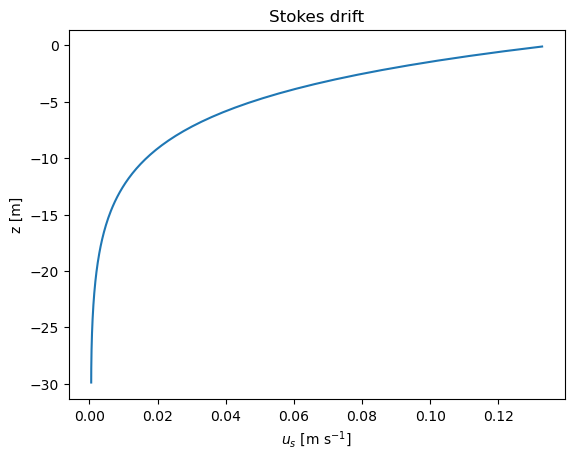

In [15]:
plt.plot(us, z)
plt.xlabel('$u_s$ [m s$^{-1}$]')
plt.ylabel('z [m]')
plt.title('Stokes drift')

Text(0.5, 1.0, 'Stokes drift shear')

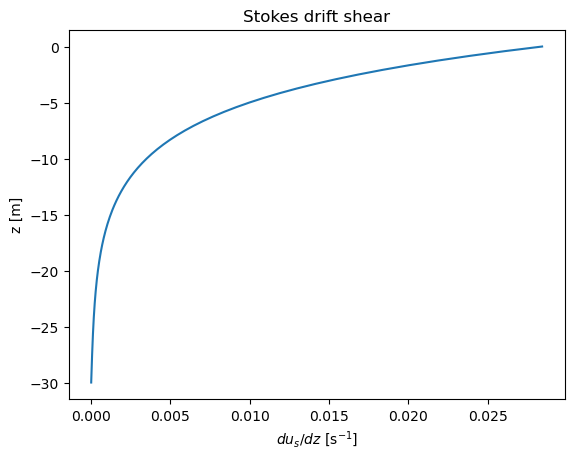

In [16]:
plt.plot(dusdz, zi)
plt.xlabel('$d u_s / dz $ [s$^{-1}$]')
plt.ylabel('z [m]')
plt.title('Stokes drift shear')

## Run the model

In [17]:
%%time
sims = m.run_batch(configs=cfgs, labels=labels, nproc=2)

CPU times: user 13.9 ms, sys: 61.2 ms, total: 75.1 ms
Wall time: 15.3 s


## Results

Load the data into an `xarray.Dataset`.

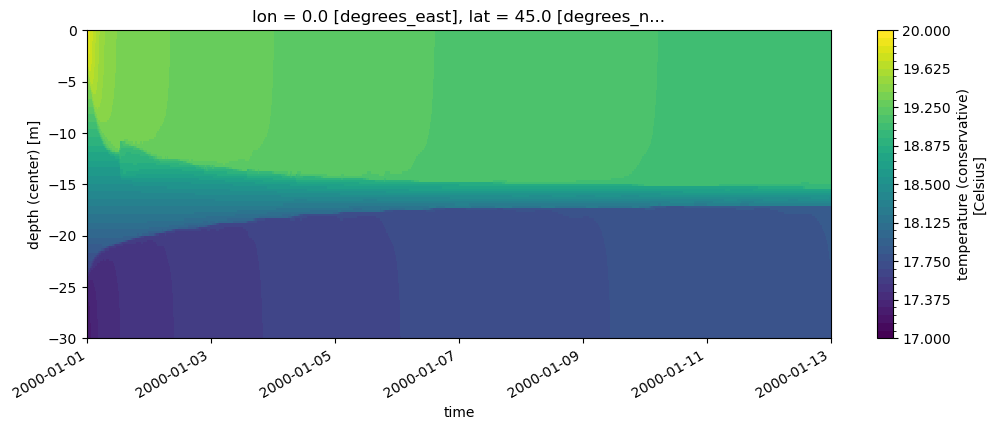

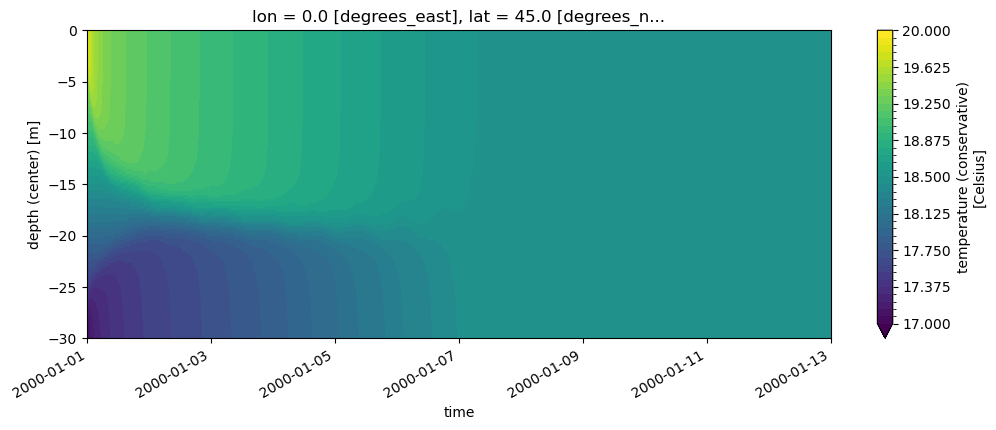

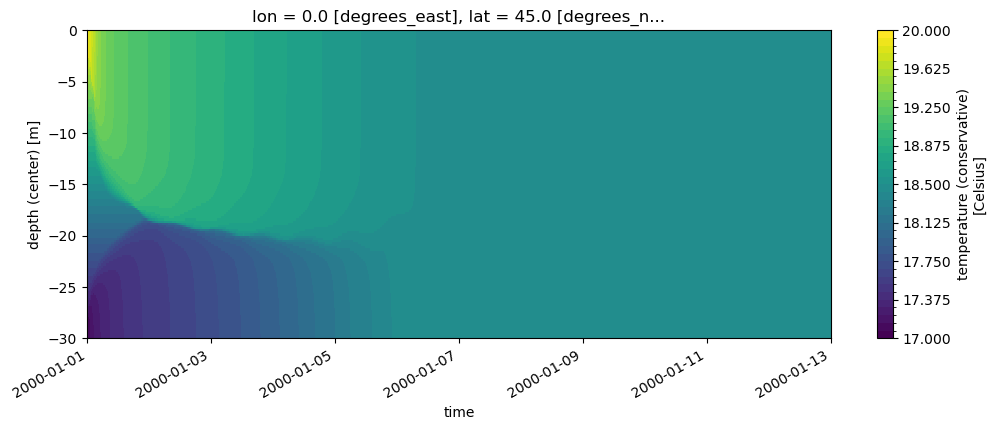

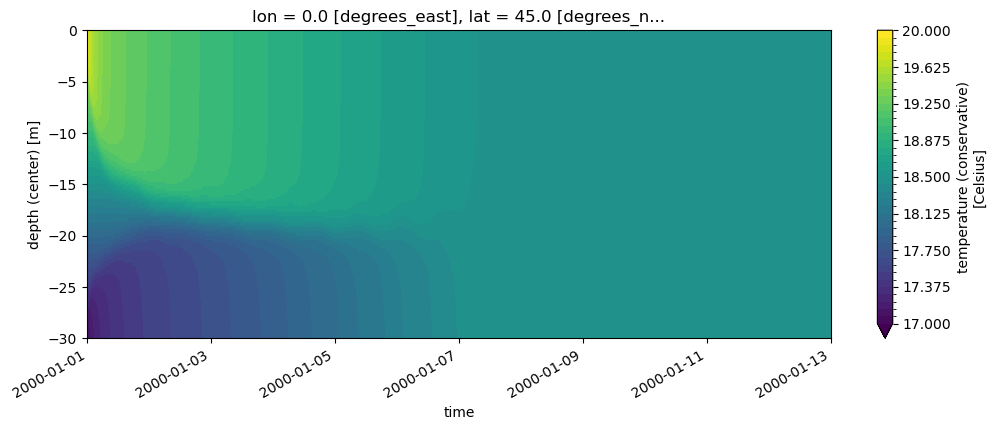

In [18]:
levels = np.linspace(17, 20, 41)
nplots = len(labels)
for i in np.arange(nplots):
    fig = plt.figure(figsize=[12,4])
    data = sims[i].load_data()
    data.data_vars['temp'].plot(levels=levels)

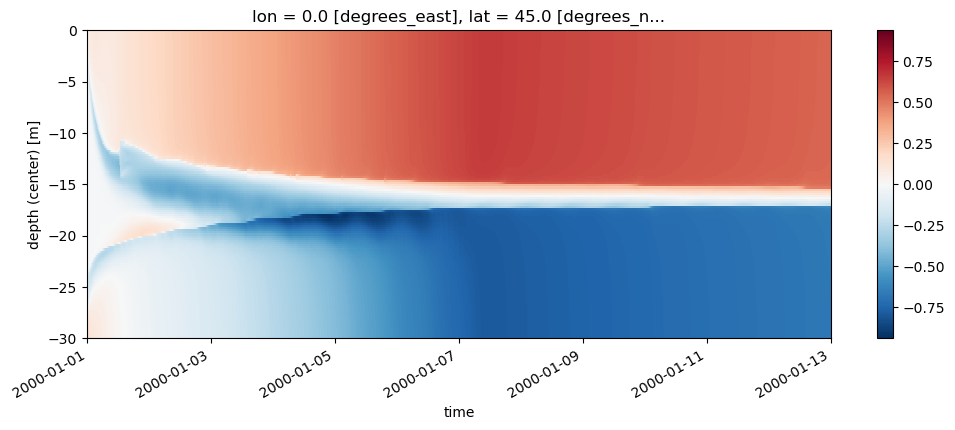

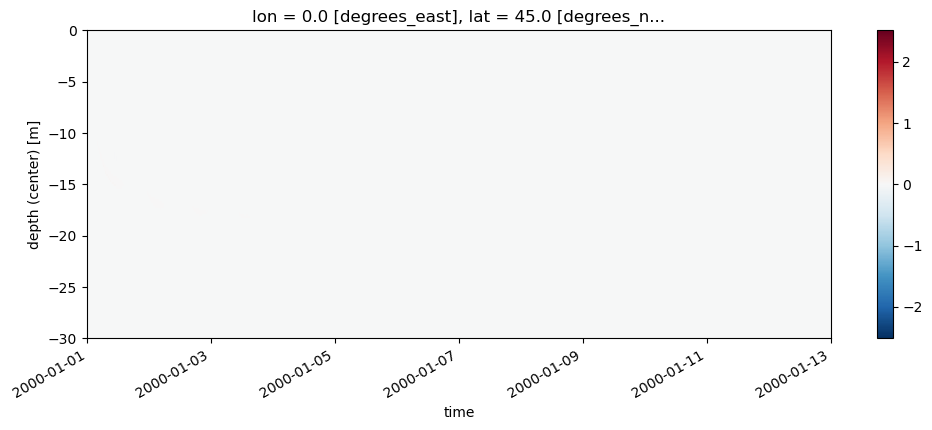

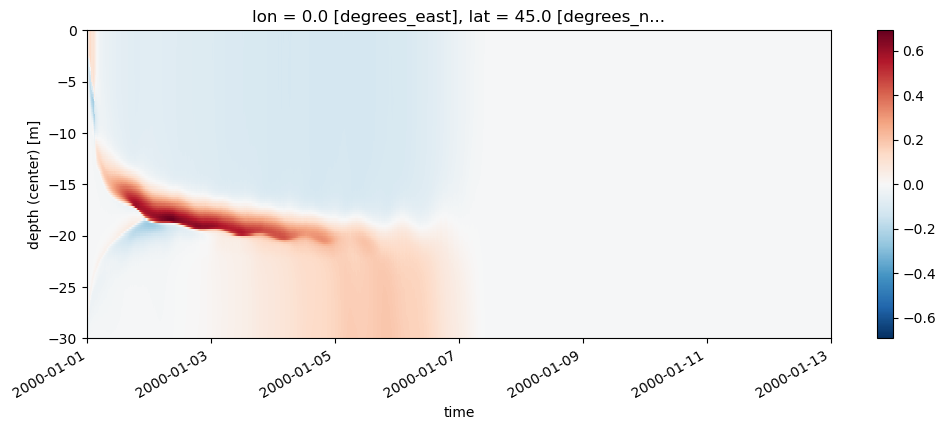

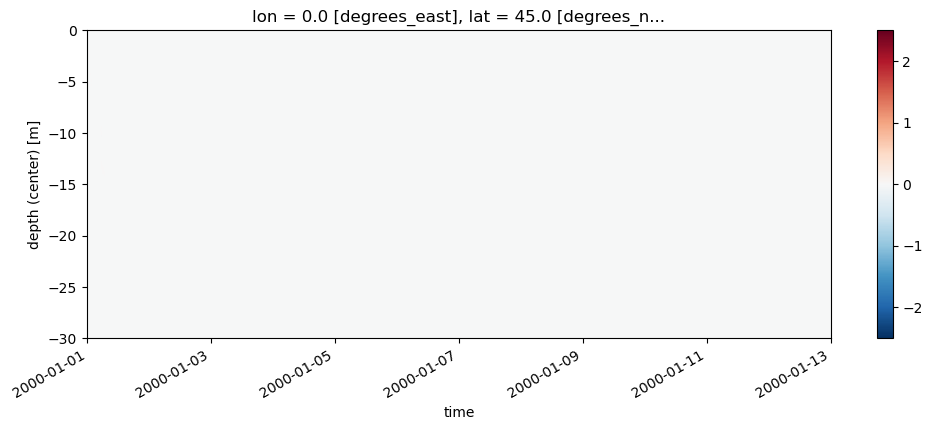

In [19]:
levels = np.linspace(17, 20, 41)
levels = None
nplots = len(labels)
for i in np.arange(nplots):
    fig = plt.figure(figsize=[12,4])
    data = sims[i].load_data()
    (data.data_vars['temp']-data.data_vars['temp_obs']).plot(levels=levels)

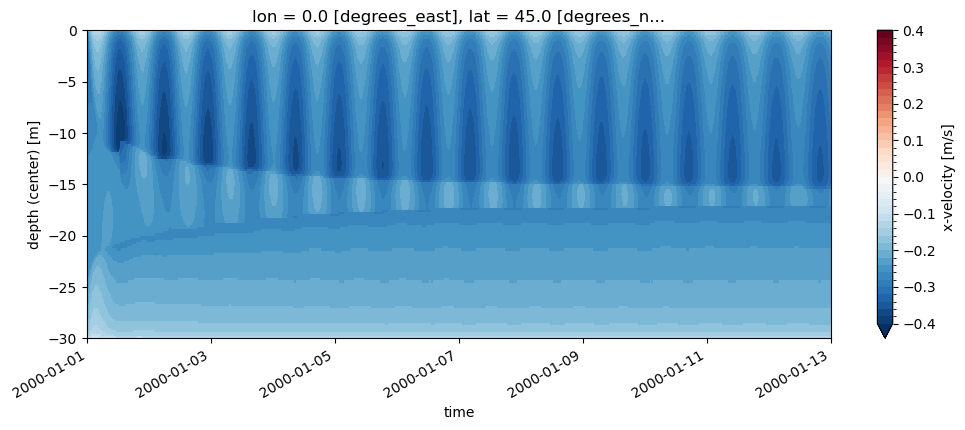

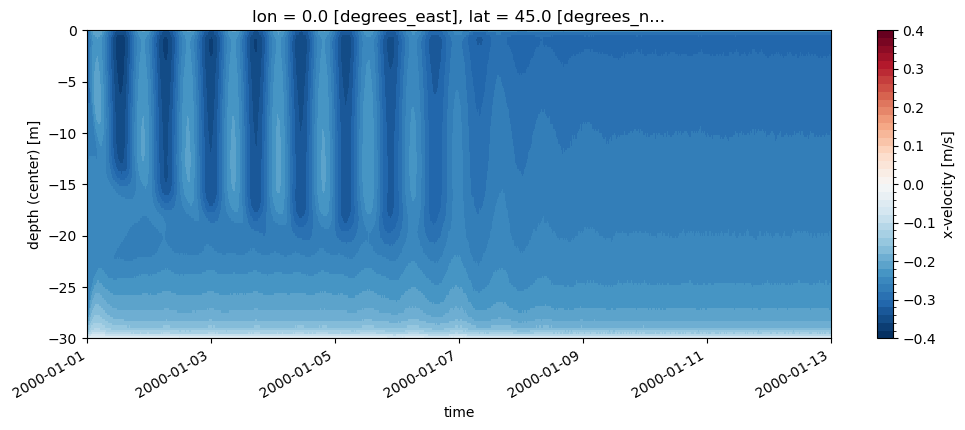

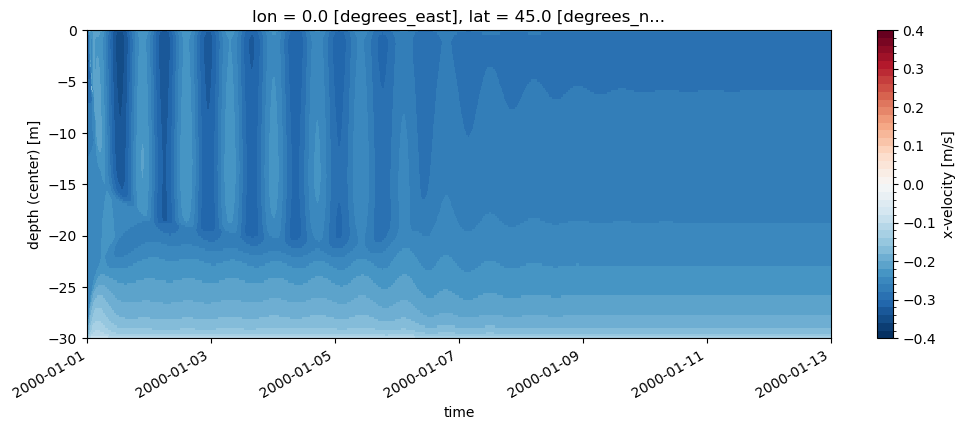

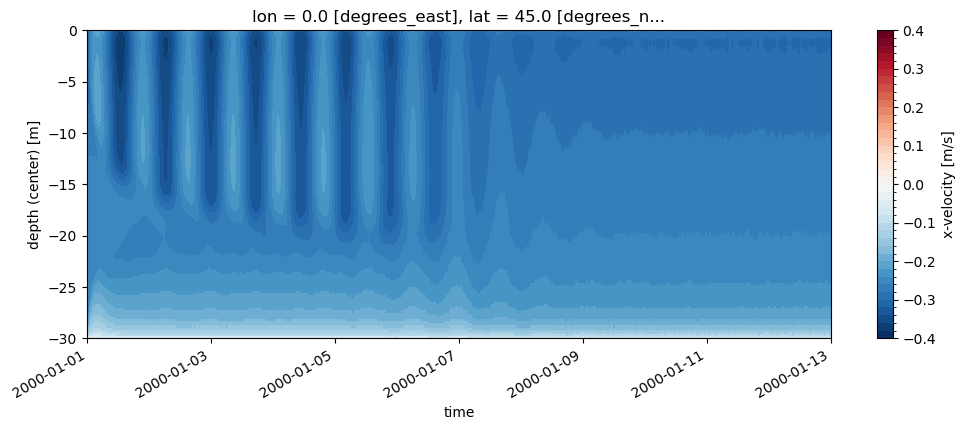

In [20]:
levels = np.linspace(-0.4, 0.4, 41)
nplots = len(labels)
for i in np.arange(nplots):
    fig = plt.figure(figsize=[12,4])
    data = sims[i].load_data()
    data.data_vars['u'].plot(levels=levels)

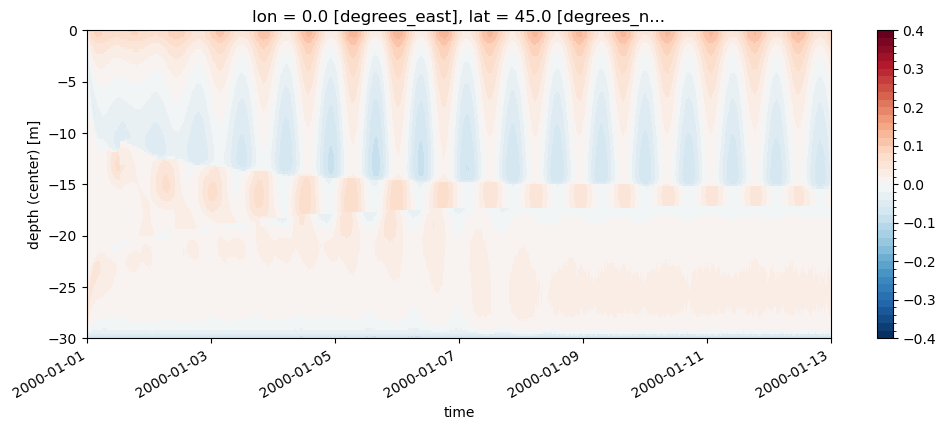

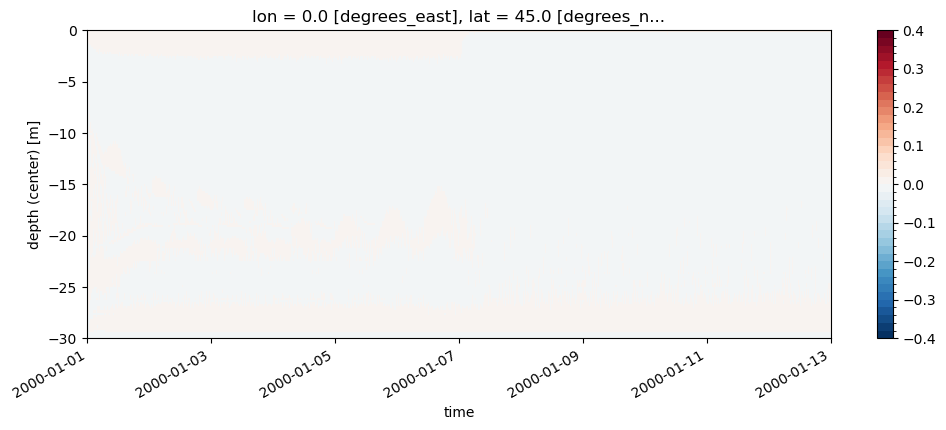

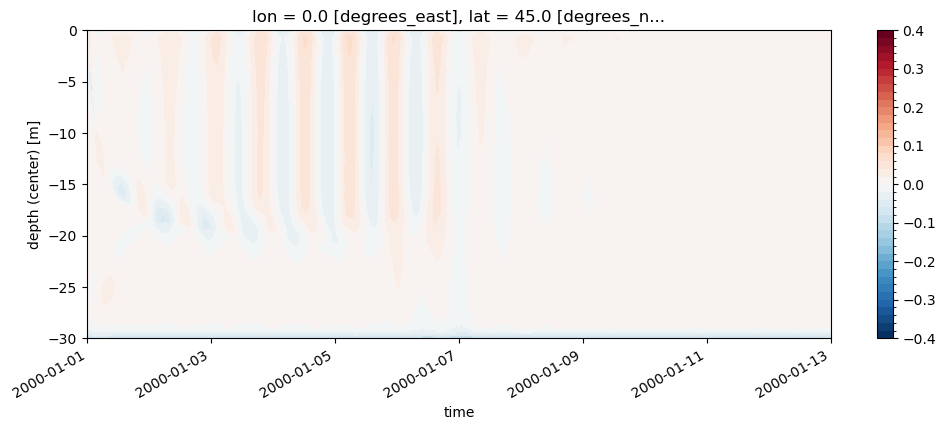

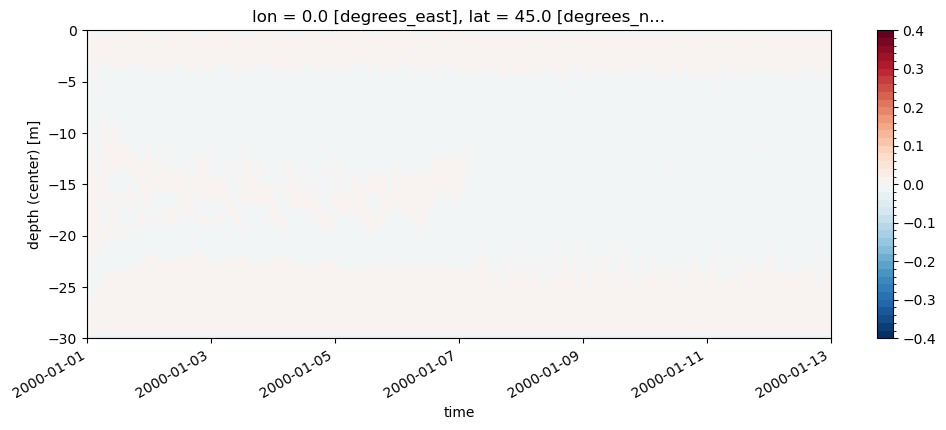

In [21]:
levels = np.linspace(-0.4, 0.4, 41)
nplots = len(labels)
for i in np.arange(nplots):
    fig = plt.figure(figsize=[12,4])
    data = sims[i].load_data()
    (data.data_vars['u']-data.data_vars['u_obs']).plot(levels=levels)

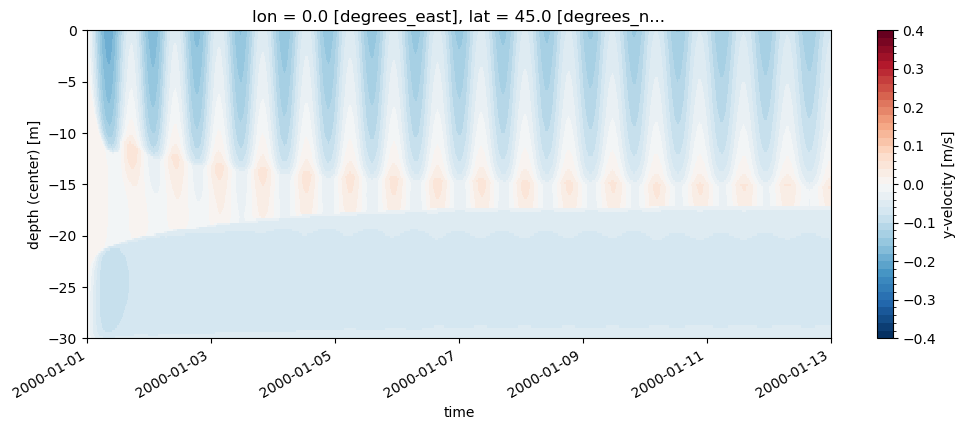

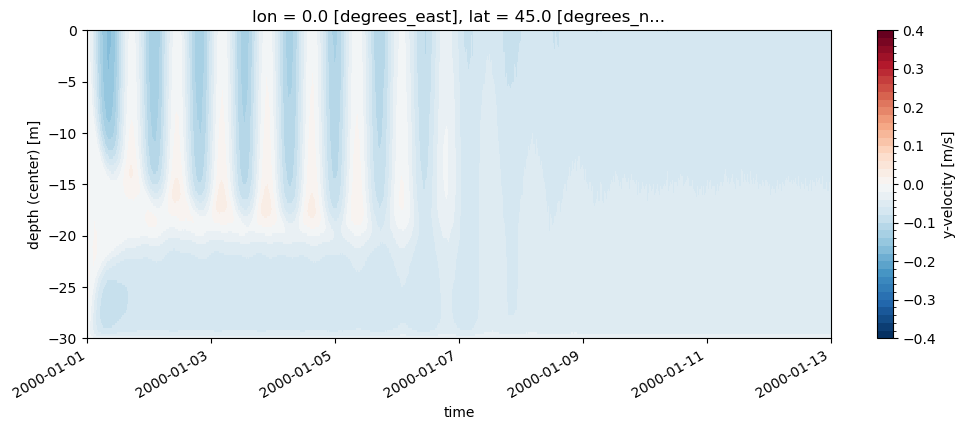

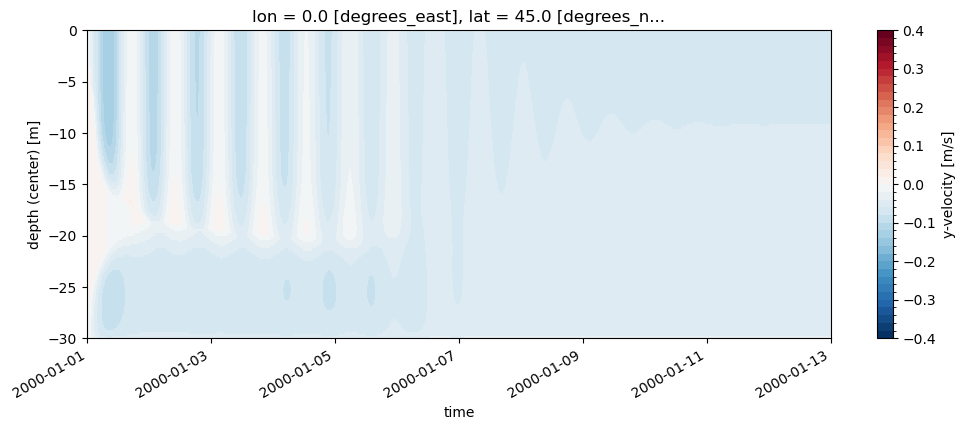

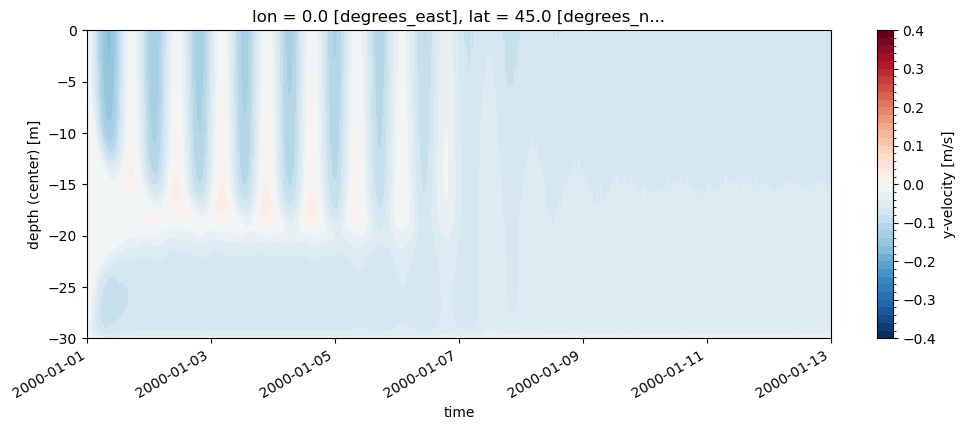

In [22]:
levels = np.linspace(-0.4, 0.4, 41)
nplots = len(labels)
for i in np.arange(nplots):
    fig = plt.figure(figsize=[12,4])
    data = sims[i].load_data()
    data.data_vars['v'].plot(levels=levels)

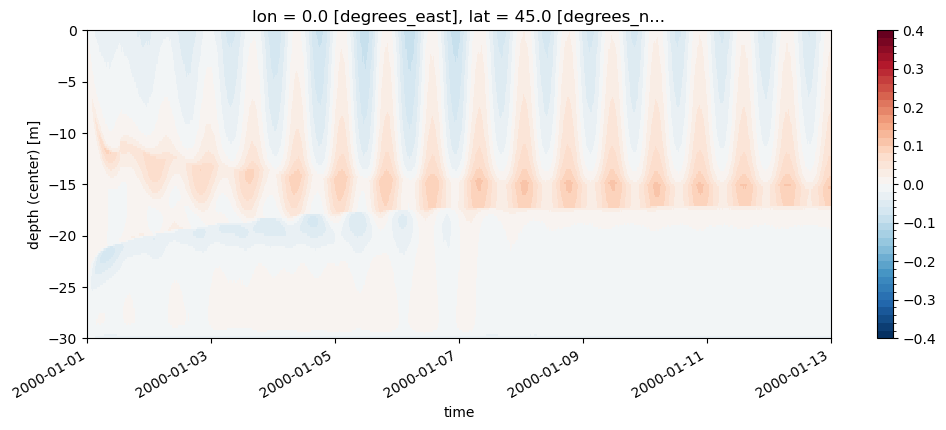

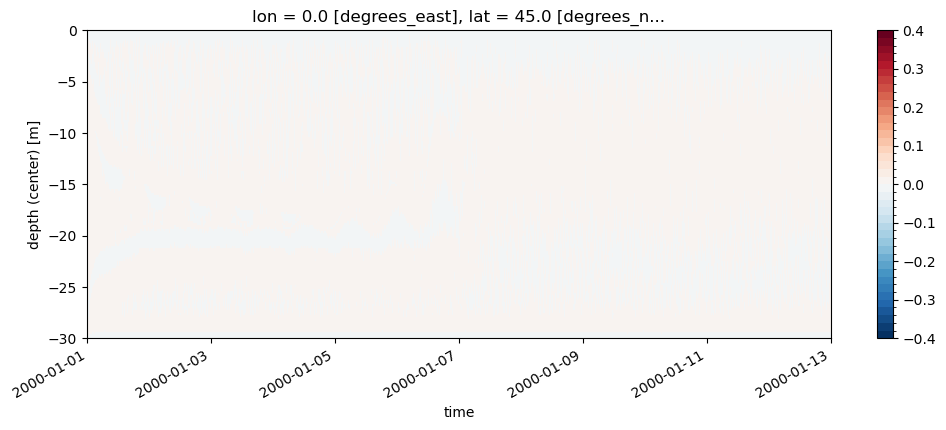

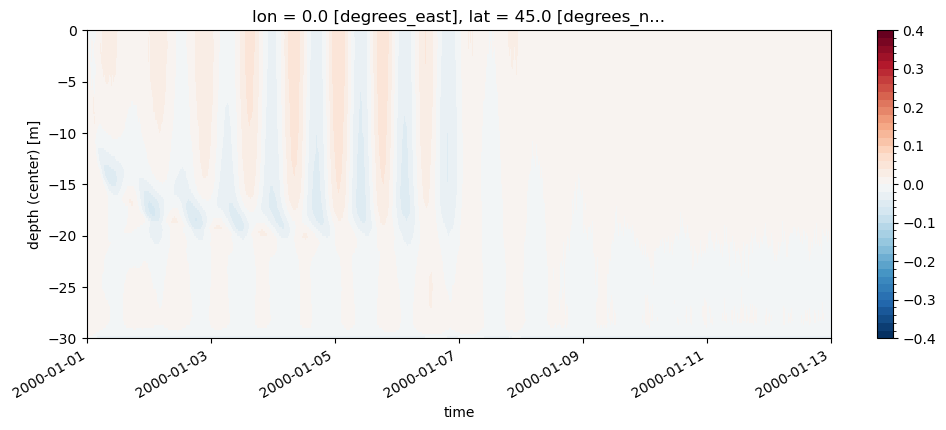

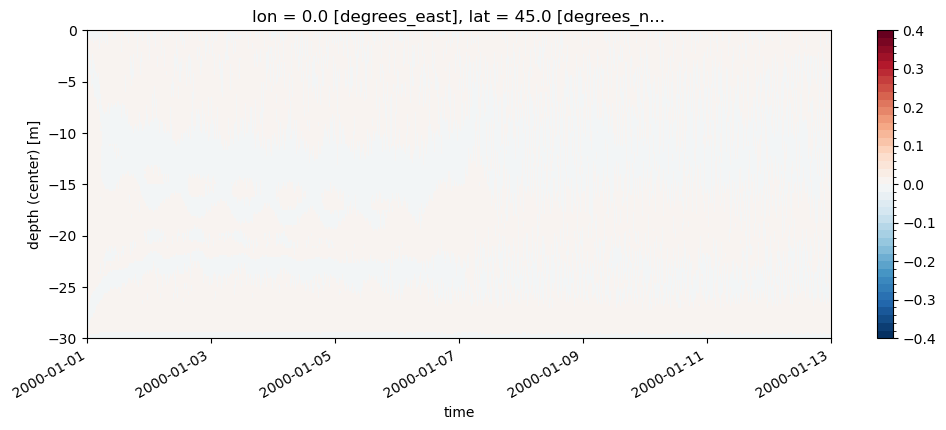

In [23]:
levels = np.linspace(-0.4, 0.4, 41)
nplots = len(labels)
for i in np.arange(nplots):
    fig = plt.figure(figsize=[12,4])
    data = sims[i].load_data()
    (data.data_vars['v']-data.data_vars['v_obs']).plot(levels=levels)

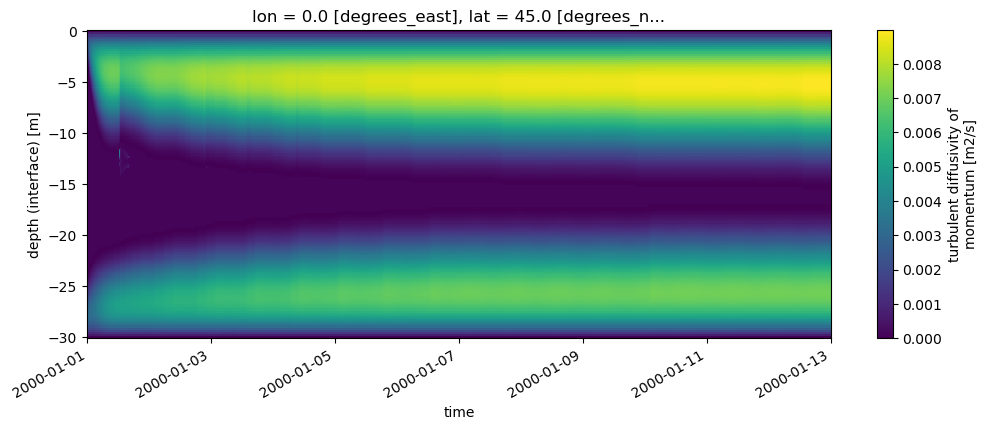

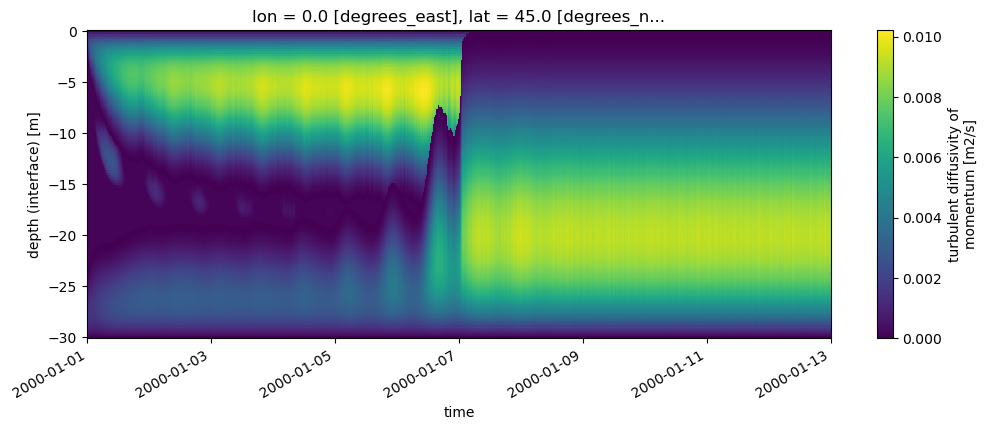

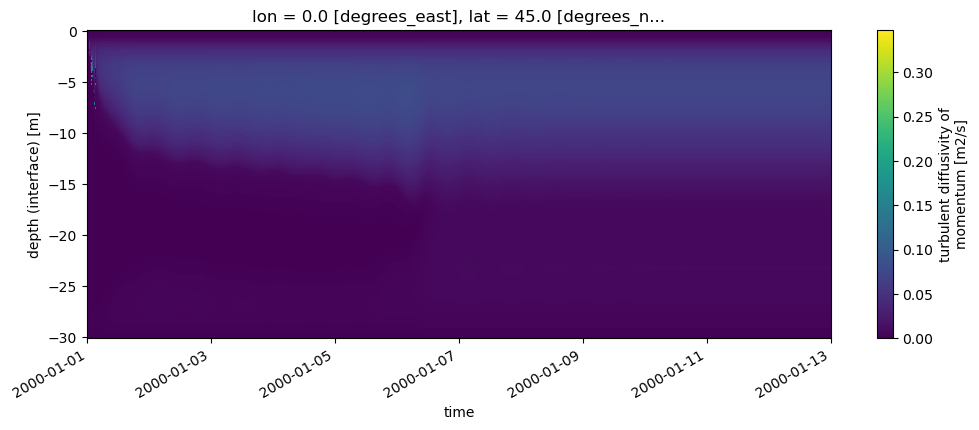

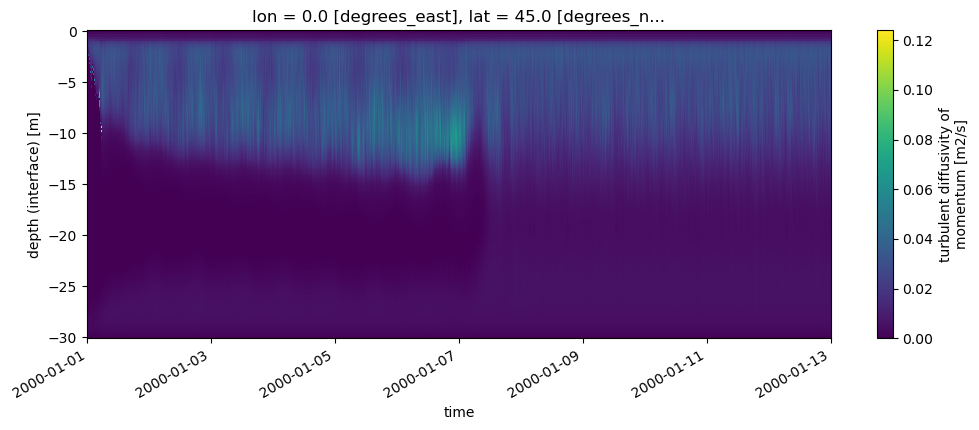

In [24]:
levels = None
nplots = len(labels)
for i in np.arange(nplots):
    fig = plt.figure(figsize=[12,4])
    data = sims[i].load_data()
    data.data_vars['num'].plot(levels=levels)

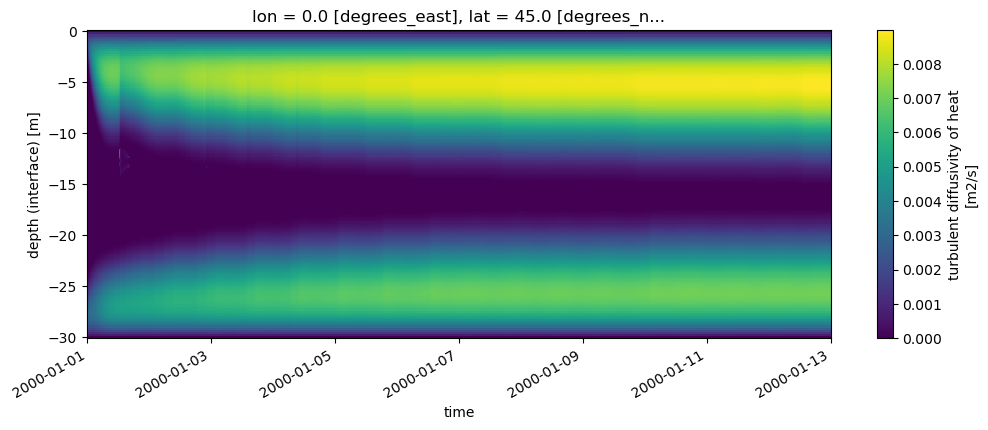

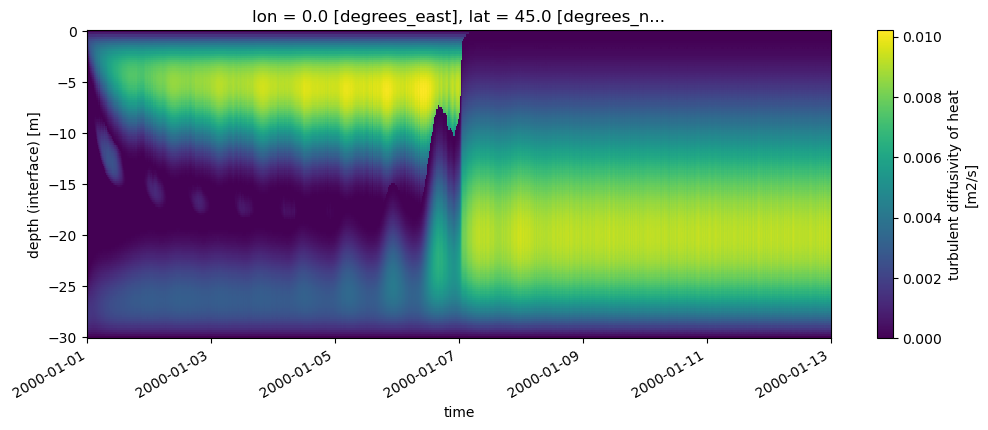

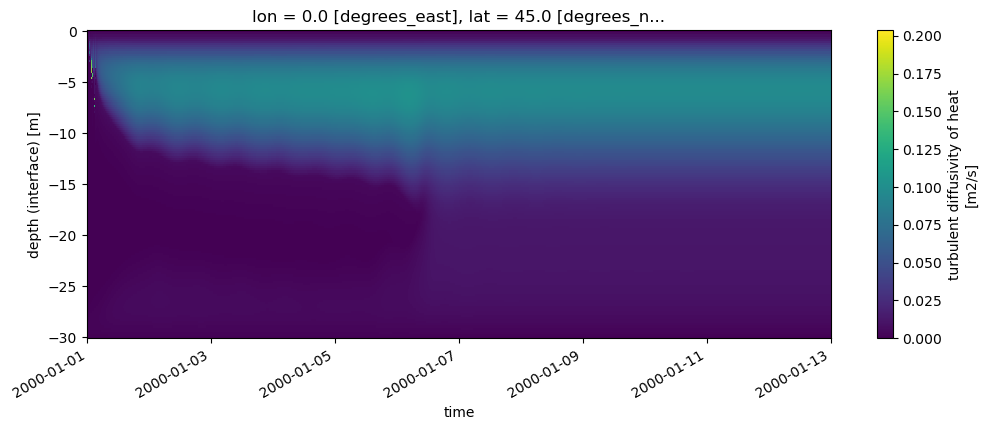

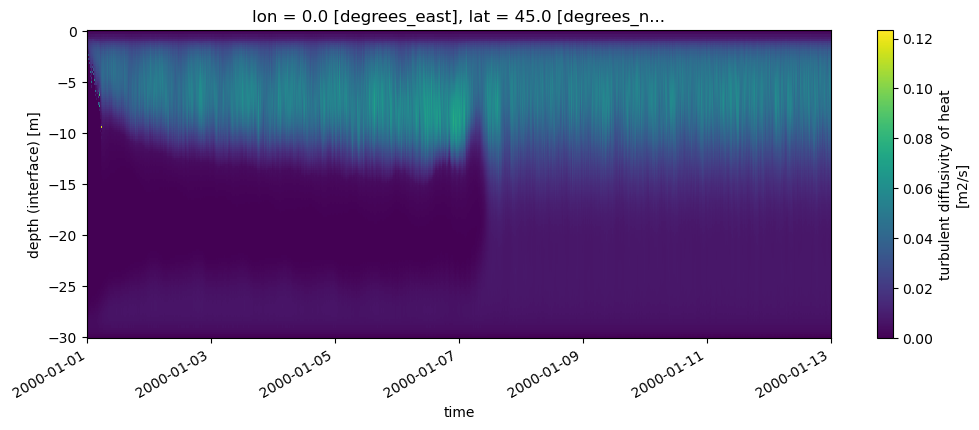

In [25]:
levels = None
nplots = len(labels)
for i in np.arange(nplots):
    fig = plt.figure(figsize=[12,4])
    data = sims[i].load_data()
    data.data_vars['nuh'].plot(levels=levels)